In [1]:
!python3 -m spacy download pt
!python3 -m spacy download en
!pip3 install -U spacy
!python3 -m spacy download pt_core_news_sm
!python3 -m spacy download en_core_web_sm
!pip3 install spacy
!pip3 install beautifulsoup4
!pip3 install html5lib

Defaulting to user installation because normal site-packages is not writeable
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/home/douglas/.local/lib/python3.8/site-packages/pt_core_news_sm -->
/home/douglas/.local/lib/python3.8/site-packages/spacy/data/pt
You can now load the model via spacy.load('pt')
Defaulting to user installation because normal site-packages is not writeable
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/home/douglas/.local/lib/python3.8/site-packages/en_core_web_sm -->
/home/douglas/.local/lib/python3.8/site-packages/spacy/data/en
You can now load the model via spacy.load('en')
Requirement already up-to-date: spacy in /home/douglas/.local/lib/python3.8/site-packages (2.3.2)
Defaulting to user installation because normal site-packages is not writeable


✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
Defaulting to user installation because normal site-packages is not writeable
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [2]:
import nltk
import spacy
from spacy import displacy 
import tqdm
import operator
import requests
from bs4 import BeautifulSoup
import re
import pt_core_news_sm
import en_core_web_sm
from collections import Counter
import random
import operator
import matplotlib.pyplot as plt
import html5lib

# Pos tagging

## Abordagem Manual

Em empresas, quando queremos construir/usar um POS Tagging, estamos buscando uma ferramenta para trabalhar em algum cenário específico e direcionado ao negócio. Por exemplo, recuperar todos os verbos de um texto, para analisar de forma geral as ações que um cliente conecta com a marca no Twitter. Nesse sentido, podemos usar duas abordagens:

    1 - Construir um modelo próprio que resolva esse cenário
    2 - Usar modelos que já existem e, se necessário, treiná-los para melhor performance no nosso cenário

Para esse exercício, vamos simular esse cenário de recuperar verbos de um texto. Apesar da abordagem 2 parecer mais interessante, vamos tentar construir nosso próprio modelo e aprender um pouco sobre a complexidade do problema.

Inicialmente, vamos reduzir bem nosso escopo, focando em

    - REGEX com NamedGoups
    - Verbos simples, como estudar
    
Use o método abaixo para verificar quais grupos foram identificados pela expressão regular:

```python
def print_found_groups(pattern, phrase):
    regex = re.compile(pattern)
    for m in regex.finditer(phrase):
        print({k:v for(k,v) in m.groupdict().items() if v is not None})
```

Mais informações de regex: https://docs.python.org/pt-br/3.8/howto/regex.html

In [7]:
def print_found_groups(pattern, phrase):
    regex = re.compile(pattern)
    for m in regex.finditer(phrase):
        print({k:v for(k,v) in m.groupdict().items() if v is not None})

In [8]:
phrase1 = "eu estudo, você estuda, nós estudamos e vc sabe como é... estudos em todo lugar "

In [13]:
estudar_pattern_try1 = r'(?P<VERB_ESTUDAR>\bestud\w?\b)'

In [14]:
print_found_groups(estudar_pattern_try1, phrase1)

{'VERB_ESTUDAR': 'estudo'}
{'VERB_ESTUDAR': 'estuda'}


<b> Atividade </b>

1) Modifique o padrão da regex para conseguir reconhecer todas as conjugações do verbo estudar na 'phrase1'

In [15]:
estudar_pattern_try1 = r'(?P<VERB_ESTUDAR>\bestud\w*?\b)'

In [16]:
print_found_groups(estudar_pattern_try1, phrase1)

{'VERB_ESTUDAR': 'estudo'}
{'VERB_ESTUDAR': 'estuda'}
{'VERB_ESTUDAR': 'estudamos'}
{'VERB_ESTUDAR': 'estudos'}


<b> Atividade </b>

2) A solução da atividade 1 trouxe todos verbos? Todas as palavras eram verbos? 

In [ ]:
Sim, mas o "estudo" que é um substantivo foi retornado como um verbo.

<b> Atividade </b>

3) Modifique o padrão da regex para identificar todos os verbos da frase abaixo. 

```python
phrase2 = "O principal uso que fazemos do canvas é ver e entregar exercícios, além de acessar os materiais postados pelos professores. É importante realizar o acesso todos os dias."
```

Observe que 'acessar' e 'acesso', apesar de serem palavras semelhantes, despenham papéis diferentes. O 'acesso' é um caso claro de polissemia. Observe as duas frases abaixo que isto ficará mais claro:

    - Meu acesso funcionou -> Aqui é substantivo
    - Eu acesso a aula -> Aqui é verbo

Utilize o método abaixo para retornar os grupos de acordo com a expressão regular construída:
```python
def get_found_groups(pattern, phrase):
    regex = re.compile(pattern)
    return {v:k for m in regex.finditer(phrase) for(k,v) in m.groupdict().items() if v is not None }
```

In [41]:
phrase2 = "O principal uso que fazemos do canvas é ver e entregar exercícios, além de acessar os materiais postados pelos professores. É importante realizar o acesso todos os dias."

In [42]:
def get_found_groups(pattern, phrase):
    regex = re.compile(pattern)
    return {v:k for m in regex.finditer(phrase) for(k,v) in m.groupdict().items() if v is not None }

In [43]:
phrase2

'O principal uso que fazemos do canvas é ver e entregar exercícios, além de acessar os materiais postados pelos professores. É importante realizar o acesso todos os dias.'

In [44]:
lista_verbos = ["uso", "faz\{0,4}", "é", "entregar", "acess\w{1,2}", "realizar"]

In [45]:
verbos_string = '|'.join(lista_verbos)

In [46]:
verbos_string

'uso|faz\\{0,4}|é|entregar|acess\\w{1,2}|realizar'

In [47]:
padrao1 =  r'(?P<VERB>'+verbos_string+')'

In [48]:
get_found_groups(padrao1, phrase2)

{'uso': 'VERB',
 'é': 'VERB',
 'entregar': 'VERB',
 'acessar': 'VERB',
 'realizar': 'VERB',
 'acesso': 'VERB'}

<b> Atividade </b>

4) Modifique o padrão da regex para identificar todos os substantivos da frase abaixo. 

```python
phrase2 = "O principal uso que fazemos do canvas é ver e entregar exercícios, além de acessar os materiais postados pelos professores. É importante realizar o acesso todos os dias."
```

Utilize o método abaixo para retornar os grupos de acordo com a expressão regular construída:
```python
def get_found_groups(pattern, phrase):
    regex = re.compile(pattern)
    return {v:k for m in regex.finditer(phrase) for(k,v) in m.groupdict().items() if v is not None }
```

In [49]:
phrase2 = "O principal uso que fazemos do canvas é ver e entregar exercícios, além de acessar os materiais postados pelos professores. É importante realizar o acesso todos os dias."

In [50]:
lista_subs = ["canvas","exercício\w{0,1}","materia\w{0,2}","professor\w{0,2}","acesso"]

In [51]:
lista_subs

['canvas',
 'exercício\\w{0,1}',
 'materia\\w{0,2}',
 'professor\\w{0,2}',
 'acesso']

In [52]:
subs_string = '|'.join(lista_subs)

In [53]:
subs_string

'canvas|exercício\\w{0,1}|materia\\w{0,2}|professor\\w{0,2}|acesso'

In [58]:
padrao2 =  r'(?P<SUBS>'+subs_string+')'

In [59]:
get_found_groups(padrao2, phrase2)

{'canvas': 'SUBS',
 'exercícios': 'SUBS',
 'materiais': 'SUBS',
 'professores': 'SUBS',
 'acesso': 'SUBS'}

<b> Atividade </b>

5) Essa abordagem de construção da regex para taggear as palavras é uma tarefa simples? Qual o valor/aplicação você consegue enxergar para ela?

In [ ]:
Não. O esforço de mapeamento das palaras é grande. Ela pode ser aplicada para tagueamento em contextos específicos.

<b> Atividade </b>

6) Nas atividades 3 e 4 você retornou todos os substantivos e verbos da phrase2. Agora marque-os na frase.  O retorno esperado da frase é: 

``O principal uso_VERB que fazemos_VERB do canvas é ver_VERB e entregar_VERB exercícios, além de acessar_VERB os materiais postados pelos professores. É importante realizar_VERB o acesso_SUBS|VERB todos os dias.``

Observe que a palavra acesso tem duas tags = SUBS e VERB.

## Mac_Morpho com NLTK

In [83]:
nltk.download('mac_morpho')
print("WORDS ", nltk.corpus.mac_morpho.tagged_words())
print("______________")
print("SENTS ",nltk.corpus.mac_morpho.tagged_sents())

[nltk_data] Downloading package mac_morpho to
[nltk_data]     /home/douglas/nltk_data...
[nltk_data]   Package mac_morpho is already up-to-date!


WORDS  [('Jersei', 'N'), ('atinge', 'V'), ('média', 'N'), ...]
______________
SENTS  [[('Jersei', 'N'), ('atinge', 'V'), ('média', 'N'), ('de', 'PREP'), ('Cr$', 'CUR'), ('1,4', 'NUM'), ('milhão', 'N'), ('em', 'PREP|+'), ('a', 'ART'), ('venda', 'N'), ('de', 'PREP|+'), ('a', 'ART'), ('Pinhal', 'NPROP'), ('em', 'PREP'), ('São', 'NPROP'), ('Paulo', 'NPROP')], [('Programe', 'V'), ('sua', 'PROADJ'), ('viagem', 'N'), ('a', 'PREP|+'), ('a', 'ART'), ('Exposição', 'NPROP'), ('Nacional', 'NPROP'), ('do', 'NPROP'), ('Zebu', 'NPROP'), (',', ','), ('que', 'PRO-KS-REL'), ('começa', 'V'), ('dia', 'N'), ('25', 'N|AP')], ...]


In [84]:
words_tagged = nltk.corpus.mac_morpho.tagged_words()

<b> Atividade </b>

7) Gere a quantidade de itens de cada tag no mac_morpho

In [86]:
tags = {}

In [87]:
for palavra in words_tagged:
    if palavra[1] not in tags.keys():
        tags[palavra[1]] = 1
    else:
        tags[palavra[1]] += 1

In [89]:
sorted(tags.items(), key=operator.itemgetter(1))

[('VAUX|!', 1),
 ('IN|EST', 1),
 ('V|!', 1),
 ('NUM|TEL', 2),
 ('PREP|', 2),
 ('KC|EST', 2),
 ('PROADJ|+', 2),
 ('PROPESS|EST', 2),
 ('PDEN|EST', 2),
 ('PROPESS|+', 2),
 ('KC|+', 2),
 ('NPRO', 3),
 ('PREP|EST', 3),
 ('`', 3),
 ('ART|EST', 4),
 ('KS|]', 4),
 ('V|EST', 5),
 ('KS|[', 5),
 ('ART|+', 7),
 ('PREP|+]', 7),
 ('PROP', 7),
 ('ADV|+', 8),
 ('PREP|]', 9),
 ('ADV|EST', 9),
 ('ADV|HOR', 9),
 ('((', 10),
 ('))', 10),
 ('ADJ|+', 11),
 ('ADV|]', 13),
 ('=', 14),
 ('ADV|[', 18),
 ('PREP|[', 20),
 ('[', 23),
 ('NPROP|+', 35),
 ('$', 60),
 ('.', 82),
 ('...', 84),
 ('/', 95),
 ('VAUX|+', 99),
 ('KC|]', 133),
 ('KC|[', 143),
 ('ADJ|EST', 174),
 ('N|DAD', 255),
 ('N|DAT', 285),
 ('ADV-KS', 392),
 ('IN', 415),
 ("'", 510),
 ('N|TEL', 866),
 ('ADV-KS-REL', 898),
 ('N|HOR', 913),
 ('!', 919),
 (';', 1376),
 ('?', 1510),
 ('PRO-KS', 2150),
 ('V|+', 2373),
 ('CUR', 2706),
 ('N|EST', 2807),
 ('-', 3117),
 ('N|AP', 4350),
 (':', 6736),
 ('PDEN', 6786),
 ('(', 7713),
 (')', 7741),
 ('PROSUB', 8598)

8) Quais são as tags mais com maior frequência? E quais com menor? Esse resultado faz sentido?

In [ ]:
As tags com maior frequência são N (substantivo), Artigo, Nome Própiro, Preposição e Verbo. Faz sentido, pois no são palaras com costumam ocorrer com maior frequências em textos.

## POS Tagging com Spacy - Desambiguando frases

Uma das aplicações do pos tagging é auxiliar na desambiguação de palavras. Uma mesma palavra pode desempenhar funções semântias diferentes, dependendo do contexto.

<b> Atividade </b>

9) Considere as frases abaixo:

9.1) frases grupo1:
```python
frase0="Ele foi andar"
frase1="O andar estava triste"
```

9.2) frase grupo2:
```python
frase2="Essa cola cola papel"
```
9.3) frases grupo3:
```python
frase3="Hora de fazer imposto de renda"
frase4="Aquilo foi imposto pelo chefe"
```

9.4) frases grupo4:
```python
frase5="Hora de fazer imposto de renda"
frase6="Aquilo foi imposto pelo chefe"
```

9.5) frases grupo5:
```python
frase7="Todo dia eu caminho"
frase8="Esse é o caminho mais fácil"
```

Utilizando o modelo ``pt_core_news_sm`` da biblioteca spacy faça as seguinte análises. Para cada token:

- a) imprima a função sintática (pos-tagging) em texto
- b) relação de dependência sintática em texto
- c) gera uma imagem das relações acims utilizando o método abaixo:
- d) análise a palavra em comum, descreva a diferença sintática encontrada e responda se é gramaticamente correta

```python
#Para imprimir detalhes
displacy.render(doc, style='dep',jupyter=True)

```

Dica: https://spacy.io/api/annotation

<b> Atividade </b>

9.1 Frases Grupo 1

In [4]:
txt0="Ele foi andar"
txt1="O andar estava triste"

In [5]:
txt0

'Ele foi andar'

In [6]:
nlp = spacy.load('pt_core_news_sm')

In [7]:
texto_nlp = nlp(txt0)

In [20]:
def analisa(texto):
    texto_nlp = nlp(texto)
    for token in texto_nlp:
        print("Token: ", token.text, "a) TAG ", token.pos_, "b) ", token.dep_)
    print("c) ")
    displacy.render(texto_nlp, style='dep',jupyter=True)          

In [21]:
analisa(txt0)

Token:  Ele a) TAG  PRON b)  nsubj
Token:  foi a) TAG  AUX b)  aux
Token:  andar a) TAG  VERB b)  ROOT
c) 


In [22]:
analisa(txt1)

Token:  O a) TAG  DET b)  det
Token:  andar a) TAG  NOUN b)  nsubj
Token:  estava a) TAG  AUX b)  cop
Token:  triste a) TAG  NOUN b)  ROOT
c) 


<b> d) Disucussão Grupo 1: </b>
Na primeira análise o "andar" foi classificado corretamento como verbo. Na segundo foi classificado corretamente como substantivo.  

<b> Atividade </b>

9.2. Frase Grupo 2

In [23]:
txt2="Essa cola cola papel"

In [24]:
analisa(txt2)

Token:  Essa a) TAG  DET b)  det
Token:  cola a) TAG  NOUN b)  nsubj
Token:  cola a) TAG  ADJ b)  ROOT
Token:  papel a) TAG  NOUN b)  obj
c) 


<b> d) Disucussão Grupo 2: </b>
A prmeira ocorrência de "cola" foi classificada corretamente como substantivo, mas a segunda foi classificada incorretamente como adjetivo. Deveria ter sido classificado como verbo.

<b> Atividade </b>

9.3. Frases Grupo 3

In [25]:
txt3="Segundo o que me disseram, ele estava triste"
txt4="No segundo dia de trabalho ela gastou menos"

In [26]:
analisa(txt3)

Token:  Segundo a) TAG  ADP b)  case
Token:  o a) TAG  PRON b)  obl
Token:  que a) TAG  PRON b)  nsubj
Token:  me a) TAG  PRON b)  obj
Token:  disseram a) TAG  VERB b)  acl:relcl
Token:  , a) TAG  PUNCT b)  punct
Token:  ele a) TAG  PRON b)  nsubj
Token:  estava a) TAG  AUX b)  cop
Token:  triste a) TAG  NOUN b)  ROOT
c) 


In [27]:
analisa(txt4)

Token:  No a) TAG  DET b)  case
Token:  segundo a) TAG  ADJ b)  amod
Token:  dia a) TAG  NOUN b)  obl
Token:  de a) TAG  ADP b)  case
Token:  trabalho a) TAG  NOUN b)  nmod
Token:  ela a) TAG  PRON b)  nsubj
Token:  gastou a) TAG  VERB b)  ROOT
Token:  menos a) TAG  ADV b)  advmod
c) 


<b> d) Disucussão Grupo 3: </b>Na txt3 a palavra "triste" foi classificada com substantivo, mas deveria ter sido classificada como adjetivo.
No txt4 todas as palavras foram classificadas corretamente.

<b> Atividade </b>

9.4. Frases Grupo 4

In [28]:
txt5="Hora de fazer imposto de renda"
txt6="Aquilo foi imposto pelo chefe"

In [29]:
analisa(txt5)

Token:  Hora a) TAG  NOUN b)  ROOT
Token:  de a) TAG  SCONJ b)  mark
Token:  fazer a) TAG  VERB b)  acl
Token:  imposto a) TAG  NOUN b)  obj
Token:  de a) TAG  ADP b)  case
Token:  renda a) TAG  NOUN b)  nmod
c) 


In [30]:
analisa(txt6)

Token:  Aquilo a) TAG  PRON b)  nsubj:pass
Token:  foi a) TAG  AUX b)  aux:pass
Token:  imposto a) TAG  VERB b)  ROOT
Token:  pelo a) TAG  DET b)  case
Token:  chefe a) TAG  NOUN b)  obl:agent
c) 


<b> d) Disucussão Grupo 4: </b> Tanto no txt5 como no txt6 todas as palavras foram classificadas corretamente.

<b> Atividade </b>

9.5. Frases Grupo 5

In [31]:
txt7="Todo dia eu caminho"
txt8="Esse é o caminho mais fácil"

In [32]:
analisa(txt7)

Token:  Todo a) TAG  DET b)  nummod
Token:  dia a) TAG  NOUN b)  obl
Token:  eu a) TAG  PRON b)  nsubj
Token:  caminho a) TAG  VERB b)  ROOT
c) 


In [33]:
analisa(txt8)

Token:  Esse a) TAG  PRON b)  nsubj
Token:  é a) TAG  AUX b)  cop
Token:  o a) TAG  DET b)  det
Token:  caminho a) TAG  NOUN b)  ROOT
Token:  mais a) TAG  ADV b)  advmod
Token:  fácil a) TAG  ADJ b)  amod
c) 


<b> d) Disucussão Grupo 5: </b> Todas as palavras do txt7 e txt8 foram classificadas corretamente.

<b> Esse modelo do spacy para português, em 79,94 de acurácia no pos-tagging</b>

<b> Atividade </b>

10) Sabendo que o modelo que estamos utulizando possui acurácia de 79,94 no pos-tagging, encontre um exemplo que ele falhe.

In [36]:
txt_curto = "Curto texto curto"

In [37]:
analisa(txt_curto)

Token:  Curto a) TAG  ADJ b)  amod
Token:  texto a) TAG  NOUN b)  ROOT
Token:  curto a) TAG  ADJ b)  amod
c) 


No exemplo acima, a primeira ocorrência de "curto" foi classificada como adjetivo, mas na verdade é um verbo.

# Named Entity Recognition

## Recomendação de sites

<b> Atividade </b>

11) Capture o texto de cada notícia abaixo:

- 0 -> https://g1.globo.com/sp/sao-paulo/noticia/2020/03/03/cai-para-130-numero-de-casos-suspeitos-de-coronavirus-no-estado-de-sao-paulo.ghtml
- 1 -> https://g1.globo.com/sp/sao-paulo/noticia/2020/03/04/ministerio-da-saude-confirma-terceiro-paciente-com-coronavirus-em-sp-um-quarto-caso-aguarda-contraprova.ghtml
- 2 -> https://g1.globo.com/bemestar/coronavirus/noticia/2020/03/04/ultimas-noticias-de-coronavirus-de-4-de-marco.ghtml
- 3 -> https://g1.globo.com/economia/noticia/2020/03/04/projetos-reduzem-em-r-96-bilhoes-emendas-parlamentares-no-orcamento-2020-diz-governo.ghtml
- 4 -> https://g1.globo.com/politica/noticia/2020/03/04/documento-liga-assessor-de-eduardo-bolsonaro-a-conta-em-rede-social-para-ataques-pessoais.ghtml
- 5 -> https://g1.globo.com/rj/rio-de-janeiro/noticia/2020/03/04/flavio-bolsonaro-entra-com-recurso-para-tentar-paralisar-investigacao-sobre-suspeita-de-rachadinha.ghtml
- 6 -> https://g1.globo.com/economia/noticia/2020/03/04/pib-do-brasil-cresce-11percent-em-2019.ghtml
- 7 -> https://g1.globo.com/economia/noticia/2020/03/04/tudo-dentro-do-previsto-diz-paulo-guedes-sobre-resultado-do-pib.ghtml
- 8 -> https://g1.globo.com/sp/santos-regiao/noticia/2020/03/04/sobe-numero-de-mortos-apos-temporal-na-baixada-santista.ghtml
- 9 -> https://g1.globo.com/sp/sao-paulo/noticia/2020/03/04/ministerio-da-saude-confirma-terceiro-paciente-com-coronavirus-em-sp-um-quarto-caso-aguarda-contraprova.ghtml

Para isto utilize o código abaixo:
```python
def match_class(target):                                                        
    def do_match(tag):                                                          
        classes = tag.get('class', [])                                          
        return all(c in classes for c in target)                                
    return do_match 

def get_text_url(url):
    res = requests.get(url)
    html = res.text
    soup = BeautifulSoup(html, 'html5lib')
    #remove marcações de scripts e style
    texto = soup.find_all(match_class(["content-text__container"]))
    all_text = ""
    for t in texto:
        all_text += t.get_text()
    return all_text
```

In [3]:
oce

In [4]:
noticias = {}
noticias[0] = "https://g1.globo.com/sp/sao-paulo/noticia/2020/03/03/cai-para-130-numero-de-casos-suspeitos-de-coronavirus-no-estado-de-sao-paulo.ghtml"
noticias[1] = "https://g1.globo.com/sp/sao-paulo/noticia/2020/03/04/ministerio-da-saude-confirma-terceiro-paciente-com-coronavirus-em-sp-um-quarto-caso-aguarda-contraprova.ghtml"
noticias[2] = "https://g1.globo.com/bemestar/coronavirus/noticia/2020/03/04/ultimas-noticias-de-coronavirus-de-4-de-marco.ghtml"
noticias[3] = "https://g1.globo.com/economia/noticia/2020/03/04/projetos-reduzem-em-r-96-bilhoes-emendas-parlamentares-no-orcamento-2020-diz-governo.ghtml"
noticias[4] = "https://g1.globo.com/politica/noticia/2020/03/04/documento-liga-assessor-de-eduardo-bolsonaro-a-conta-em-rede-social-para-ataques-pessoais.ghtml"
noticias[5] = "https://g1.globo.com/rj/rio-de-janeiro/noticia/2020/03/04/flavio-bolsonaro-entra-com-recurso-para-tentar-paralisar-investigacao-sobre-suspeita-de-rachadinha.ghtml"
noticias[6] = "https://g1.globo.com/economia/noticia/2020/03/04/pib-do-brasil-cresce-11percent-em-2019.ghtml"
noticias[7] = "https://g1.globo.com/economia/noticia/2020/03/04/tudo-dentro-do-previsto-diz-paulo-guedes-sobre-resultado-do-pib.ghtml"
noticias[8] = "https://g1.globo.com/sp/santos-regiao/noticia/2020/03/04/sobe-numero-de-mortos-apos-temporal-na-baixada-santista.ghtml"
noticias[9] = "https://g1.globo.com/sp/sao-paulo/noticia/2020/03/04/ministerio-da-saude-confirma-terceiro-paciente-com-coronavirus-em-sp-um-quarto-caso-aguarda-contraprova.ghtml"

In [5]:
noticias

{0: 'https://g1.globo.com/sp/sao-paulo/noticia/2020/03/03/cai-para-130-numero-de-casos-suspeitos-de-coronavirus-no-estado-de-sao-paulo.ghtml',
 1: 'https://g1.globo.com/sp/sao-paulo/noticia/2020/03/04/ministerio-da-saude-confirma-terceiro-paciente-com-coronavirus-em-sp-um-quarto-caso-aguarda-contraprova.ghtml',
 2: 'https://g1.globo.com/bemestar/coronavirus/noticia/2020/03/04/ultimas-noticias-de-coronavirus-de-4-de-marco.ghtml',
 3: 'https://g1.globo.com/economia/noticia/2020/03/04/projetos-reduzem-em-r-96-bilhoes-emendas-parlamentares-no-orcamento-2020-diz-governo.ghtml',
 4: 'https://g1.globo.com/politica/noticia/2020/03/04/documento-liga-assessor-de-eduardo-bolsonaro-a-conta-em-rede-social-para-ataques-pessoais.ghtml',
 5: 'https://g1.globo.com/rj/rio-de-janeiro/noticia/2020/03/04/flavio-bolsonaro-entra-com-recurso-para-tentar-paralisar-investigacao-sobre-suspeita-de-rachadinha.ghtml',
 6: 'https://g1.globo.com/economia/noticia/2020/03/04/pib-do-brasil-cresce-11percent-em-2019.ghtml

In [6]:
get_text_url("https://g1.globo.com/sp/sao-paulo/noticia/2020/03/04/ministerio-da-saude-confirma-terceiro-paciente-com-coronavirus-em-sp-um-quarto-caso-aguarda-contraprova.ghtml")

' O Ministério da Saúde, em conjunto com as secretarias estadual e municipal de São Paulo, confirmou nesta quarta-feira (4) o terceiro caso de coronavírus no Brasil. O homem é natural da Colômbia, tem 46 anos, é administrador de empresas, mora em São Paulo, e viajou para a Itália, Áustria, Alemanha e Espanha.  Ele desembarcou no Brasil no dia 1º de março, procurou atendimento médico com sintomas de tosse, coriza e desconforto na garganta e teve a confirmação para COVID-19 nesta quarta-feira (4) no Hospital Albert Einstein, na Zona Sul de São Paulo.  (O G1 informou, com base em informações do coordenador do Centro de Contingência de São Paulo, David Uip, que o terceiro paciente confirmado é uma criança que viajou para a Itália. Na verdade, trata-se de um homem que viajou para países da Europa. A informação foi corrigida às 17h45).   Os dois primeiros casos também foram confirmados no Einstein. Todos os três pacientes estão bem, em isolamento domiciliar, e tiveram histórico de viagem par

In [7]:
texto_noticias = {i:get_text_url(noticias[i]) for i in noticias.keys()}

In [90]:
texto_noticias[0]

' A Secretaria Estadual de Saúde de São Paulo divulgou nesta terça-feira (3) que caiu o número de pacientes com suspeita de coronavírus no estado. Enquanto na segunda-feira (2) eram 163 casos suspeitos, nesta terça são 130.  Foram descartados, ao todo, 104 casos no estado, destes, 56 foram nas últimas 24 horas. Entretanto, segundo informou a pasta, entre segunda (2) e terça (3), 23 novos surgiram.  Permanecem confirmados apenas 2 casos da doença no país, ambos no estado de São Paulo. Os pacientes estão em quarentena domiciliar. Ambos estiveram em viagem na Itália.  "Os dois confirmados estão evoluindo bem clinicamente, mas ainda têm alguns sintomas que fazem com que eles continuem em isolamento domiciliar", salientou Paulo Menezes, coordenador do comitê de operações emergenciais (COE) da Secretaria Estadual de Saúde.  O número de pessoas que tiveram contato com o segundo caso confirmado não foi divulgado pela secretaria. No primeiro caso confirmado, eram 34 pessoas, entre passageiros d

<b> Atividade </b>

12) Capture as entidades de cada uma das notícias utilizando o modelo ``pt_core_news_sm`` do spacy.

<i> Dica: ents retorna as entidades de um texto </i>

In [9]:
nlp = pt_core_news_sm.load()

In [14]:
texto_noticias_nlp = {i:nlp(texto_noticias[i]) for i in noticias.keys()}

In [95]:
entidades = {i:set(map(str,nlp(texto_noticias[i]).ents)) for i in noticias.keys()}

In [96]:
entidades[0]

{'A Organização Mundial de Saúde',
 'A Secretaria Estadual de Saúde de São Paulo',
 'Adolfo Lutz',
 'COE',
 'CVE',
 'Campanha Nacional de Vacinação',
 'Centro de Contingenciamento de Emergências',
 'Centro de Vigilância Epidemiológica',
 'Covid-19',
 'David Uip',
 'H1N1',
 'Helena Sato',
 'Instituto Butantan',
 'Itália',
 'José Henrique Germann',
 'Menezes',
 'Milão',
 'Ministério da Saúde',
 'OMS',
 'Paulo Menezes',
 'Permanecem',
 'Saúde',
 'Secretaria Estadual de Saúde',
 'Secretário de Estado da Saúde',
 'São Paulo',
 'Uip',
 'estado de São Paulo'}

<b> Atividade </b>

13) Quais são as 5 entidades que mais apareceram nas notíciais? Critique esse resultado, ele faz sentido?

In [17]:
todas_entidades = []

In [19]:
for k in entidades.keys():
    todas_entidades.extend(entidades[k])

In [22]:
dict(Counter(todas_entidades))

{'Centro de Contingência': 10,
 'Covid-19': 10,
 'PSDB': 10,
 'OMS': 10,
 'Hospital Albert Einstein': 10,
 'Áustria': 10,
 'de São Paulo': 10,
 'H1N1': 10,
 'Campanha Nacional de Vacinação': 10,
 'Instituto Adolfo Lutz': 10,
 'Brasil': 10,
 'João Doria': 10,
 'Itália': 10,
 'O Ministério da Saúde': 10,
 'A Organização Mundial de Saúde': 10,
 'Europa': 10,
 'Milão': 10,
 'Ministério da Saúde': 10,
 'Einstein': 10,
 'Centro de Contingência de São Paulo': 10,
 'Colômbia': 10,
 'Menezes': 10,
 'David Uip': 10,
 'Turim': 10,
 'Zona Sul de São Paulo': 10,
 'Saúde': 10,
 'Espanha': 10,
 'G1': 10,
 'Paulo Menezes': 10,
 'São Paulo': 10,
 'A tendência': 10,
 'estado de São Paulo': 10,
 'Adolfo Lutz': 10,
 'Portugal': 10,
 'Secretaria Estadual de Saúde': 10,
 'COE': 10,
 'Secretaria de Saúde do Estado de São Paulo': 10,
 'Uip': 10,
 'Alemanha': 10,
 'Hospital Beneficência Portuguesa': 10}

O resultado faz sentido, pois as noticias são relacionas ao início da pandemia de COVID. São Paulo e Itália são muito citados nos textos.

<b> Atividade </b>

14) Para a notítica 0, imprima quais foram os tipos das entidades encontradas e plote um gráfico com esses dados.
Faça uma análise desse resultado

<i> Dica: label_ retorna o nome da entidade </i>

In [23]:
texto_noticias_nlp[0].ents[0].label_

'MISC'

In [25]:
labels = [entidade.label_ for entidade in texto_noticias_nlp[0].ents]

In [29]:
labels = Counter(labels)

<BarContainer object of 4 artists>

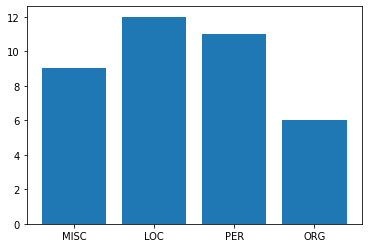

In [30]:
plt.bar(labels.keys(), labels.values())

<b> Atividade </b>

15) Plote um gráfico com esses dados com todos os tipos das entidades de todas as notícias. Compare este resultado com o resultado da notícia 0.

In [73]:
labels = []

In [74]:
for i in range(len(texto_noticias_nlp)):
    temp = [entidade.label_ for entidade in texto_noticias_nlp[i].ents]
    labels.append(temp)

In [75]:
dict_counter = [dict(Counter(label)) for label in labels]

In [76]:
dict_counter

[{'MISC': 9, 'LOC': 12, 'PER': 11, 'ORG': 6},
 {'MISC': 11, 'LOC': 32, 'ORG': 6, 'PER': 7},
 {'LOC': 9, 'PER': 1},
 {'LOC': 11, 'MISC': 11, 'PER': 5, 'ORG': 4},
 {'PER': 21, 'ORG': 3, 'MISC': 11, 'LOC': 9},
 {'PER': 2, 'ORG': 1, 'LOC': 8},
 {'MISC': 11, 'LOC': 13, 'PER': 5, 'ORG': 3},
 {'PER': 7, 'ORG': 3, 'LOC': 13, 'MISC': 3},
 {'LOC': 50, 'ORG': 4, 'MISC': 4, 'PER': 1},
 {'MISC': 11, 'LOC': 32, 'ORG': 6, 'PER': 7}]

In [77]:
dict_all = {}

In [78]:
for dictionary in dict_counter:
    for k in dictionary.keys():
        if k not in dict_all:
            dict_all[k] = dictionary[k]
        else:
            dict_all[k] += dictionary[k]

In [79]:
dict_all

{'MISC': 71, 'LOC': 189, 'PER': 67, 'ORG': 36}

<BarContainer object of 4 artists>

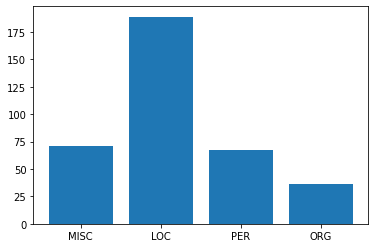

In [80]:
plt.bar(dict_all.keys(), dict_all.values())

As tags de localidade são predominantes nos textos. Possivelmente por conter várias referências à lugares São Paulo, locais físicos como centros de saúde e Itália.

<b> Atividade </b>

16) Imprima a notícia 0, colorindo as entidades encontradas, para isto utilize o método abaixo:

```python
displacy.render(doc, jupyter=True, style='ent')
```

<i> Dica: entidades que existem no spacy https://spacy.io/api/annotation#section-named-entities 

Caso tenha dúvida sobre alguma marcalçao use:</i>

```python
spacy.explain("MISC")
```

In [81]:
displacy.render(texto_noticias_nlp[0], jupyter=True, style='ent')

<b> Atividade </b>

17) Seja o documento 0 sua referência. Calcule a similaridade das entidades do documento 0 com todos outros 9. Para calcular a similaridade utilize o método jacard (implementado na aula 3). 

In [82]:
def jaccard_similarity(f1, f2):
    f1 = set(f1)
    f2 = set(f2)
    
    intersecao = f1.intersection(f2)
    uniao = f1.union(f2)
    
    return len(intersecao) / len(uniao)

In [86]:
entidades[1]

{'A Organização Mundial de Saúde',
 'A tendência',
 'Adolfo Lutz',
 'Alemanha',
 'Brasil',
 'COE',
 'Campanha Nacional de Vacinação',
 'Centro de Contingência',
 'Centro de Contingência de São Paulo',
 'Colômbia',
 'Covid-19',
 'David Uip',
 'Einstein',
 'Espanha',
 'Europa',
 'G1',
 'H1N1',
 'Hospital Albert Einstein',
 'Hospital Beneficência Portuguesa',
 'Instituto Adolfo Lutz',
 'Itália',
 'João Doria',
 'Menezes',
 'Milão',
 'Ministério da Saúde',
 'O Ministério da Saúde',
 'OMS',
 'PSDB',
 'Paulo Menezes',
 'Portugal',
 'Saúde',
 'Secretaria Estadual de Saúde',
 'Secretaria de Saúde do Estado de São Paulo',
 'São Paulo',
 'Turim',
 'Uip',
 'Zona Sul de São Paulo',
 'de São Paulo',
 'estado de São Paulo',
 'Áustria'}

In [98]:
for i in range(0,10):
    print(jaccard_similarity(entidades[0], entidades[i]))

1.0
0.3673469387755102
0.03125
0.0
0.0
0.0
0.0
0.0
0.016666666666666666
0.3673469387755102


<b> Atividade </b>

18) Com os cálculos da questão anterior, responda: quais foram os três documentos com maior similaridade? Eles posssuem conteúdos semelhantes? E qual o documento com menor similaridade? Este documento faz sentido?

## Retreino NER

Aqui nós iremos ilustrar como treinar um modelo NER no spacy

In [99]:
nlp = spacy.load("pt_core_news_sm")

In [100]:
texto = "João nasceu em Paris em 01/01/2000"

In [101]:
texto_nlp = nlp(texto)

In [ ]:
displacy.render(texto_nlp, style='ent',jupyter=True)

Observe que o modelo identifica <b> João </b> como pessoa e <b> Paris </b> como localidade.

Apesar do modelo ter identificado essas duas entidades ele naõ identificou a <b> data </b>.

Assim, aqui iremos mostrar como retreinar o modelo para capturar também a data.


In [102]:
#dados de treino. Note que para cada frase, a posição de uma determinada entidade.
train_data = [
("Em 04/12/1992 nasceu Joana", {'entities':[(3, 13, "DATE"), (21,26, "PER")]}),
("Data de início: 10/01/2018", {'entities':[(16, 26, "DATE")]}),
("Maria se mudou para Paris", {'entities':[(20,26, "LOC")]}),
("Paris cidade das luzes", {'entities':[(0,5, "LOC")]}),    
("Maria nasceu em Contagem no dia 07/05/2018", {'entities':[(0,5,"PER"),(16,24,"LOC"),(32,42, "DATE")]})
]

### Retreino

- explosion/spaCy/master/examples/training/train_ner.py -> O spcay disponibiliza esse código para treinamentos.
- Mais informações? https://spacy.io/usage/training

In [103]:
def train_spacy(data, iterations):
    TRAIN_DATA = data
    nlp = spacy.blank('pt')  # create blank Language class
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner, last=True)
       

    # add labels
    for _, annotations in TRAIN_DATA:
         for ent in annotations.get('entities'):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        optimizer = nlp.begin_training()
        for itn in range(iterations):
            random.shuffle(TRAIN_DATA)
            losses = {}
            for text, annotations in TRAIN_DATA:
                nlp.update(
                    [text],  # batch of texts
                    [annotations],  # batch of annotations
                    drop=0.2,  # dropout - make it harder to memorise data
                    sgd=optimizer,  # callable to update weights
                    losses=losses)           
    return nlp

In [104]:
modelo_novo = train_spacy(train_data, 30)

/home/douglas/.local/lib/python3.8/site-packages/spacy/language.py:635: UserWarning: [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you have the spacy-lookups-data package installed. The languages with lexeme normalization tables are currently: da, de, el, en, id, lb, pt, ru, sr, ta, th.
  proc.begin_training(
/home/douglas/.local/lib/python3.8/site-packages/spacy/language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "Maria se mudou para Paris" with entities "[(20, 26, 'LOC')]". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


In [105]:
modelo_novo.to_disk("modelo_novo_NER")

<b> Atividade </b>

19) O ``modelo_novo`` já foi criado. Aplique o texto em que demonstramos que a data não foi identificada e depois imprima utilizando o ``displacy``.
O problema foi resolvido? E se mudarmos o formato da data, ele reconhce? Quais outras entidades o modelo não consegue reconhecer? 

In [107]:
texto_nlp = modelo_novo(texto)

In [108]:
displacy.render(texto_nlp, style='ent',jupyter=True)